# Задача 1

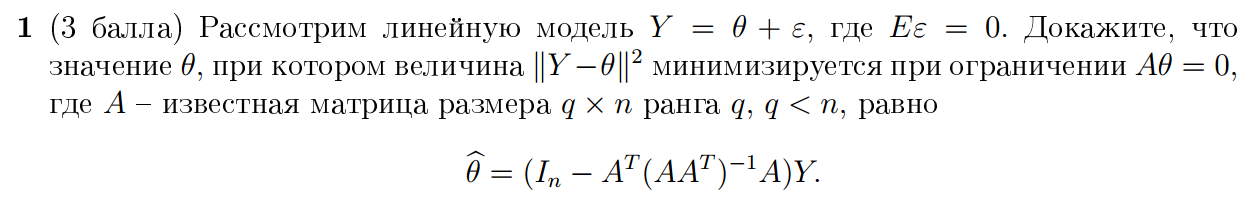

$\newcommand{\norm}[1]{\left\lVert#1\right\rVert}$
$\newcommand{\lr}[1]{\left(#1\right)}$

Решается задача
$$\min_{s.t.\ A\theta = 0}\norm{Y - \theta}^2$$

То есть ищется проекция $Pr_{A^\bot}Y$

Не стану переписывать доказательство [Формулы (p.430)](https://personal.utdallas.edu/~jwz120030/Teaching/M4355/Books/MeyerMatrixAnalysis.pdf)

Матрица $A^\mathsf{T}$ задаёт подпространство $\mathbb{R}^n$ с базисом из $q$ векторов
$$Pr_{A^\mathsf{T}}Y = A^\mathsf{T}\lr{AA^\mathsf{T}}^{-1}A$$
$$Pr_{A^\mathsf{T}} = I - Pr_{A^\bot}$$
Итого, $$\hat{\theta} = Pr_{A^\bot}Y = \lr{I - A^\mathsf{T}\lr{AA^\mathsf{T}}^{-1}A}Y$$

In [130]:
import numpy as np
import scipy.stats as sps
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import sklearn
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
sns.set(style="darkgrid", font_scale=1.4)
plt.style.use("dark_background")
sns.set_palette(sns.color_palette("Paired"))

# Задача 2

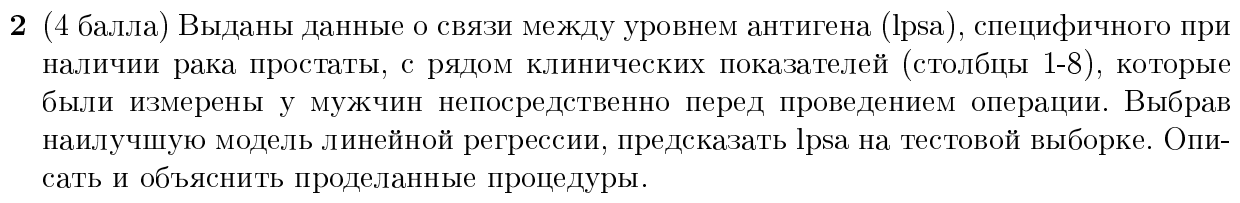

In [131]:
df = pd.DataFrame(pd.read_csv("msps2018-hw9-2/Prostate_train.csv"))
train = df.dropna(how='any').reset_index().drop(columns=['index'])
train

,id,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783
1,2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519
2,3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519
3,4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519
4,5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564
...,...,...,...,...,...,...,...,...,...,...
63,91,3.246491,4.101817,68,-1.386294,0,-1.386294,6,0,4.029806
64,92,2.532903,3.677566,61,1.348073,1,-1.386294,7,15,4.129551
65,93,2.830268,3.876396,68,-1.386294,1,1.321756,7,60,4.385147
66,94,3.821004,3.896909,44,-1.386294,1,2.169054,7,40,4.684443


In [132]:
X = train.drop(columns=['lpsa', 'id']) # data
y = train['lpsa']                      # target

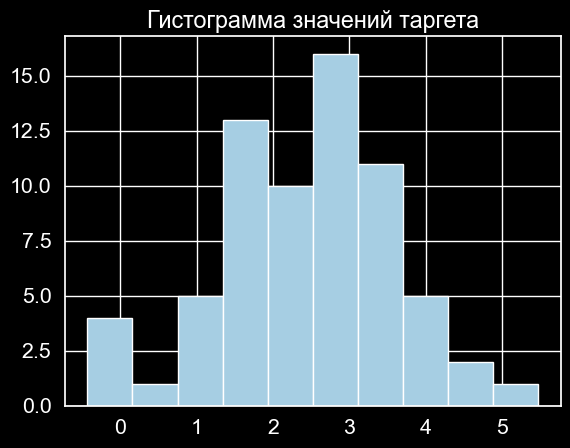

In [133]:
y.hist()
plt.title("Гистограмма значений таргета");

Гистограммы значений фичей

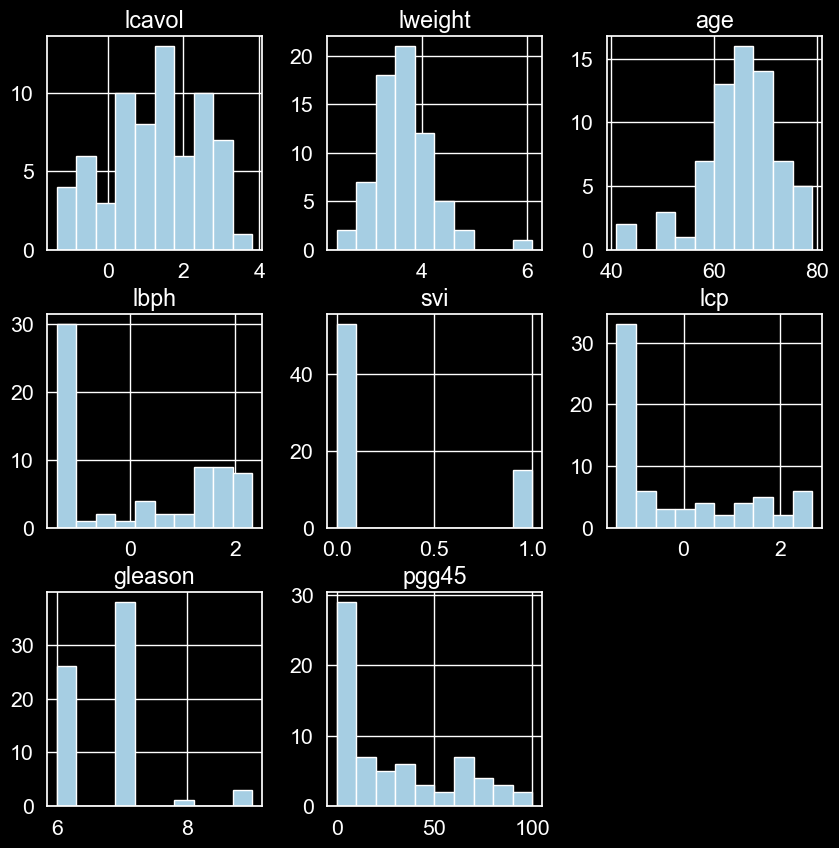

In [134]:
X.hist(figsize=(10, 10));

Стандартизируем данные

In [135]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

Строим регрессию

In [136]:
cls = LinearRegression().fit(X, y);

Коэффициенты(веса)

In [137]:
cls.coef_

array([ 0.743012  ,  0.23047827, -0.12510311,  0.23210819,  0.31266231,
       -0.28606074, -0.02918509,  0.27717145])

Сдвиг

In [138]:
cls.intercept_

2.4458137455882354

Коэффициент детерминации

In [139]:
cls.score(X, y)

0.6822017443997476

Коэффициент детерминации $R^2 = 0.68$ не высокий, но тем более не околонулевой. 

Исследуем получившуюся модель:

### 1. Анализ остатков:

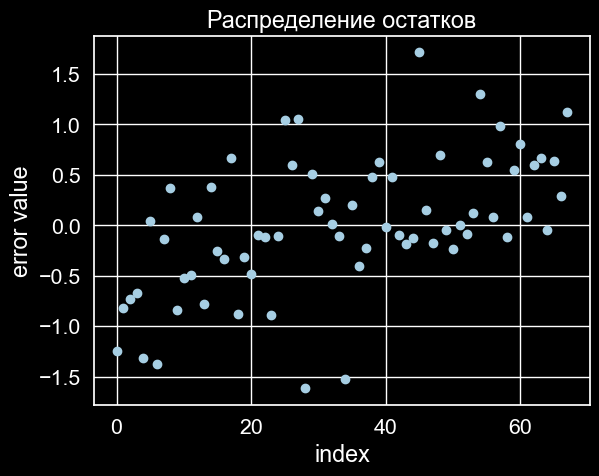

In [140]:
plt.plot(y - cls.predict(X), 'o')
plt.title("Распределение остатков")
plt.ylabel('error value')
plt.xlabel('index');

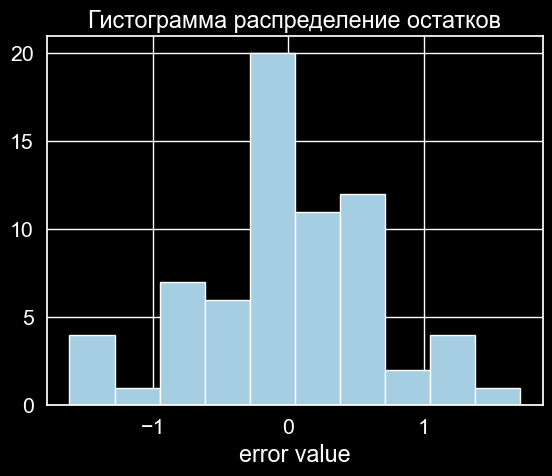

In [141]:
plt.hist(y - cls.predict(X), bins=10)
plt.title("Гистограмма распределение остатков")
plt.xlabel('error value');

Стьюдентизированные остатки

$$X \in \mathbb{R}^{n \times k}, \quad y \in \mathbb{R} \\ RSS = \sum_{i=1}^n(y_i - \hat{y_i})^2 \\ \hat{\sigma}^2 = \frac{RSS}{n-k-1} \\ H = (X^\mathsf{T}X)^{-1}X^\mathsf{T} \\ d_i = \frac{y_i - \hat{y_i}}{\sqrt{\frac{RSS}{n-k}}\sqrt{1 - h_{ii}}}$$

In [142]:
n = X.shape[0]
k = X.shape[1]

In [143]:
H = X.dot(np.linalg.inv(X.T.dot(X))).dot(X.T)
RSS = ((y - cls.predict(X)) ** 2).sum()
std = RSS / (n - k - 1)
d = (y - cls.predict(X)) / np.sqrt(std) / np.sqrt(1 - np.diag(H))

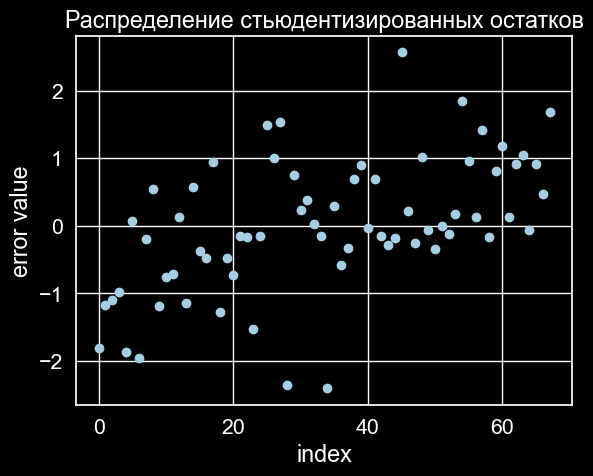

In [144]:
plt.plot(d, 'o')
plt.title("Распределение стьюдентизированных остатков")
plt.ylabel('error value')
plt.xlabel('index');

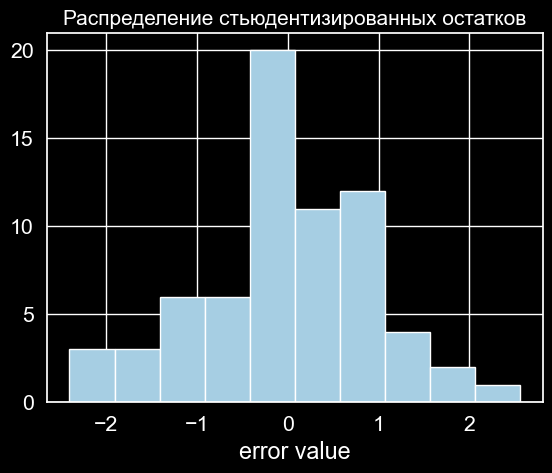

In [145]:
plt.hist(d, bins=10)
plt.title("Распределение стьюдентизированных остатков", fontsize=15)
plt.xlabel('error value');

In [146]:
sps.normaltest(d)

NormaltestResult(statistic=0.8628396727978582, pvalue=0.6495861336147349)

pvalue велико (0.65), так что гипотезу о нормальности ошибок не отвергаем. 

В самом деле, распределение ошибок похоже на нормальное, что видно из следующих графиков:

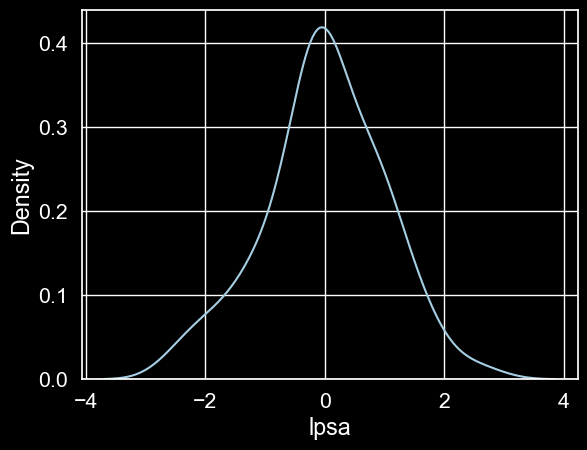

In [147]:
sns.kdeplot(d);

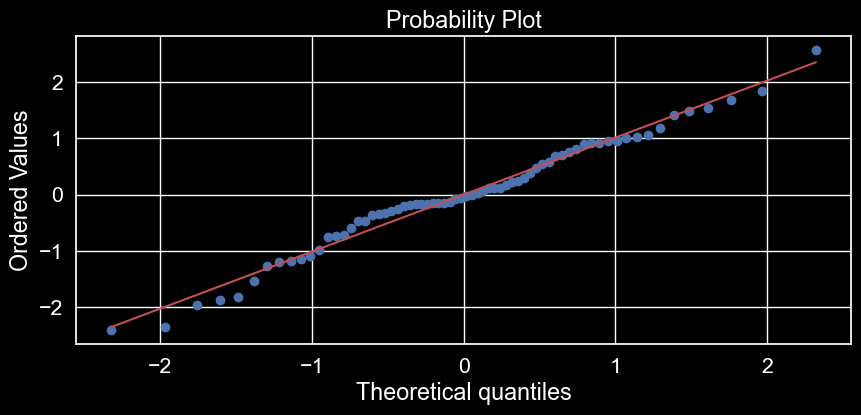

In [148]:
import pylab 
plt.figure(figsize=(10, 4))
sps.probplot(d, dist="norm", plot=pylab);

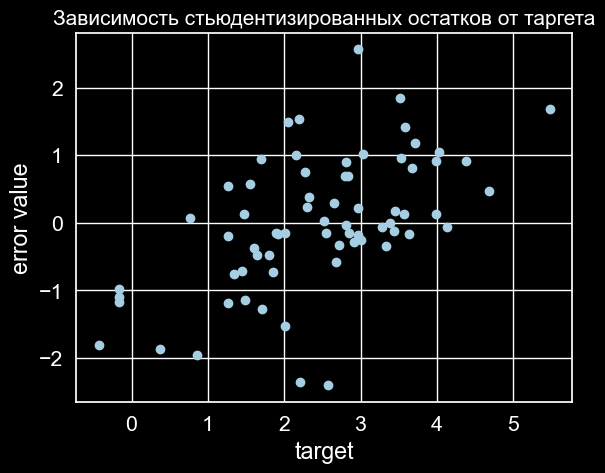

In [149]:
plt.plot(y, d, 'o')
plt.title("Зависимость стьюдентизированных остатков от таргета", fontsize=15)
plt.ylabel('error value')
plt.xlabel('target');

С ростом таргета, ошибка смещается в положительную сторону.

Значит, наша модель скорее всего не полна

Посмотрим на зависимость ошибки от каждой из фичей

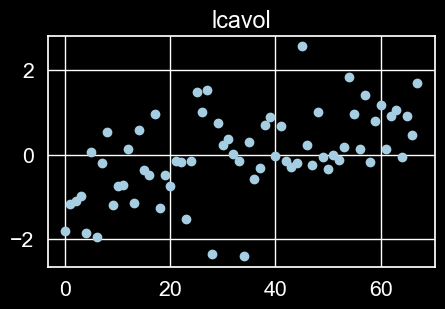

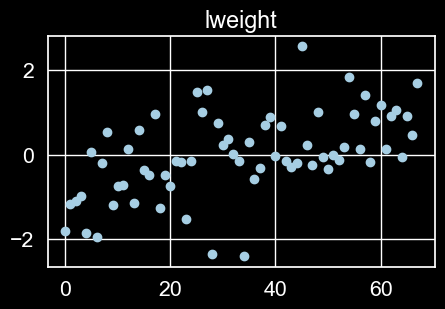

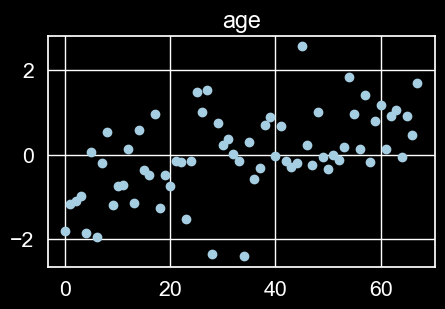

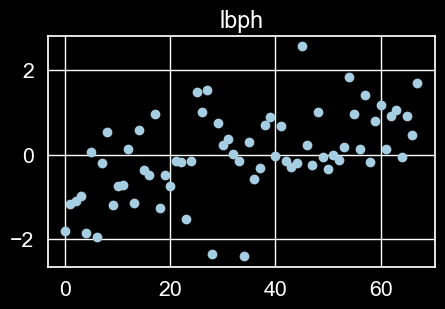

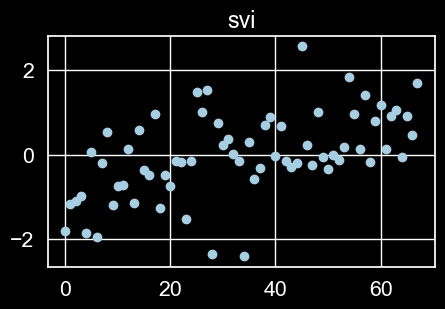

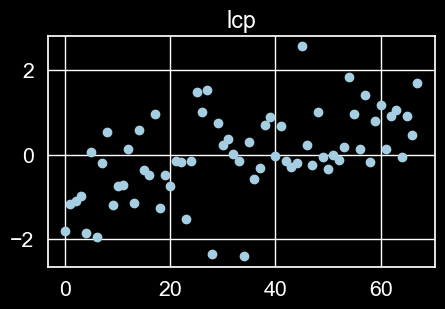

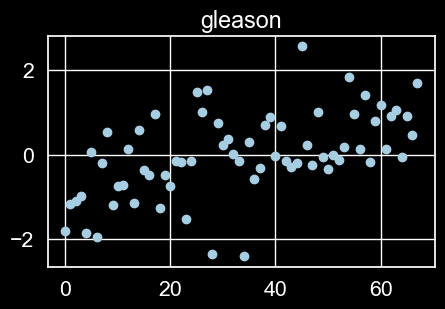

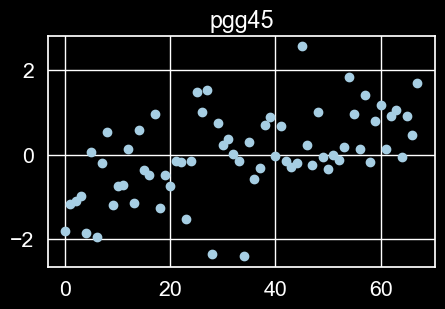

In [150]:
for i in range(k):
    plt.figure(figsize=(5, 3))
    plt.plot(d[X[:, i].argsort()], 'o')
    plt.title(train.columns[i+1])

### 2. Попробуем преобразовать фичи

Судя по тому, что ошибка начинала смещаться в плюс с ростом нашего таргета, возможно, есть какие-то нелинейные зависимости таргета от имеющихся фичей.
Это можно проверить с помощью критерия RESET Рэмси https://en.wikipedia.org/wiki/Ramsey_RESET_test. 

Проверим, есть ли степенная зависимость:

In [151]:
z = cls.predict(X).reshape((-1, 1))
X_reset = np.hstack([X, z ** 2, z ** 3, z ** 4, z ** 5])  # reshape((-1, 1)) the unspecified value is inferred to be n
cls_reset = LinearRegression().fit(X_reset, y)
y_reset = cls_reset.predict(X_reset)

In [152]:
RSS_new = ((y - y_reset) ** 2).sum()
RSS_new

24.29898454998839

In [153]:
RSS

30.659839888731238

In [154]:
F = (RSS - RSS_new) / std

In [155]:
sps.f.sf(F, 1, n - k - 1)

0.0008962479157131853

F - статистика менее 5%, отвергаем гипотезу, что коэффициенты при степенях таргета одновременно нули

Нормализуем фичи

In [156]:
X_normalized = sklearn.preprocessing.normalize(X)
cls_normalized = LinearRegression().fit(X_normalized, y)
cls_normalized.score(X_normalized, y)

0.6723503163079779

Применим преобразование Бокса-Кокса

In [157]:
X_boxcox = np.array([
    sps.boxcox((X - X.min(axis=0) + 0.001)[:, i])[0] for i in range(k)
]).T
cls_boxcox = LinearRegression().fit(X_boxcox, y)
cls_boxcox.score(X_boxcox, y)

0.6838390467675739

А теперь вместе - Бокс-Кокс для нормализованных

In [158]:
X_norm_boxcox = np.array([
    sps.boxcox((X_normalized - X_normalized.min(axis=0) + 0.001)[:, i])[0] for i in range(k)
]).T
cls_norm_boxcox = LinearRegression().fit(X_norm_boxcox, y)
cls_norm_boxcox.score(X_norm_boxcox, y)

0.6572466576104838

Исходный же коэффициент детерминации $R^2$

In [159]:
cls.score(X, y)

0.6822017443997476

Итого, преобразование Бокса-Кокса даёт небольшой прирост $R^2$, а нормализация его только уменьшает

Применим ортогонализацию Грама-Шмидта:

In [160]:
X_gram_schmidt = np.linalg.qr(X)[0]
cls_gram_schmidt = LinearRegression().fit(X_gram_schmidt, y)
cls_gram_schmidt.score(X_gram_schmidt, y)

0.6822017443997476

In [161]:
cls_gram_schmidt.score(X_gram_schmidt, y) - cls.score(X, y)

0.0

Значит, фичи и так ортогональны

### 3. Попробуем исключить некоторые признаки

Критерий Стьюдента

In [162]:
from scipy.stats import t
import statsmodels
import statsmodels.stats
import statsmodels.stats.outliers_influence
from statsmodels.tools import add_constant


def calc_student_intervals(X, y, alpha=0.05):
    k = X.shape[1]
    n = X.shape[0]
    
    X = np.matrix(X)
    X_ = add_constant(X)
    
    Z = np.linalg.inv(X_.T @ X_)
    beta = np.array(Z @ X_.T @ np.matrix(y).T).reshape(-1)
    
    y_hat = np.array(X_ @ np.matrix(beta).T).reshape(-1)
    sigma = np.sqrt(np.sum((y_hat - y)**2)/(n-k))
    return list(zip(beta - t.ppf(1.0 - alpha / 2.0, n - k - 1) * sigma * np.sqrt(np.diag(Z)),
               beta + t.ppf(1.0 - alpha / 2.0, n - k - 1) * sigma * np.sqrt(np.diag(Z))))[1:]

In [163]:
student_intervals = calc_student_intervals(X, y, 0.05)

In [164]:
student_intervals

[(0.4806544413007658, 1.0053695653111168),
 (0.026253308104704998, 0.43470323892849655),
 (-0.3261724349615737, 0.07596621788158237),
 (0.028034573063364376, 0.4361818035472416),
 (0.06422569930940736, 0.5610989257396966),
 (-0.5939245765426688, 0.021803097459610787),
 (-0.31328987801587904, 0.2549196965881687),
 (-0.04044391966957861, 0.5947868235307833)]

In [165]:
[_ for _, interval in enumerate(student_intervals) if (interval[0] < 0.0 < interval[1])]

[2, 5, 6, 7]

Критерием Стьюдента можно отбросить критерии с номерами выше

In [166]:
X_no_stud = X[:, [0, 1, 3, 4]]
cls_no_temp = LinearRegression().fit(X_no_stud, y)
score_no_stud = cls_no_temp.score(X_no_stud, y)
score_no_stud

0.6488935506507885

Изначальный $R^2$

In [167]:
cls.score(X, y)

0.6822017443997476

Коэффициент детерминации упал, фичи не убираем

Variance inflation factor

In [168]:
[
    [statsmodels.stats.outliers_influence.variance_inflation_factor(add_constant(X), i), train.columns[i+1]]
    for i in range(k+1)
][:-1]

[[1.0, 'lcavol'],
 [2.2876273648863754, 'lweight'],
 [1.3861676919788697, 'age'],
 [1.3436611367638984, 'lbph'],
 [1.3841138884621147, 'svi'],
 [2.0513006151522566, 'lcp'],
 [3.15003562637265, 'gleason'],
 [2.6825956356297866, 'pgg45']]

Фичей с VIF > 5 (рекомендованный порог) нет. Удалим же фичу с максимальным VIF, то есть gleason

In [169]:
X_no_gleason = X[:, [0, 1, 2, 3, 4, 5, 7]]
cls_no_temp = LinearRegression().fit(X_no_gleason, y)
score_no_gleason = cls_no_temp.score(X_no_gleason, y)
score_no_gleason

0.6819779457713355

Теперь $R^2$ только упал

In [170]:
X_no_pgg = X[:, :-1]
cls_no_temp = LinearRegression().fit(X_no_pgg, y)
score_no_pgg = cls_no_temp.score(X_no_pgg, y)
score_no_pgg

0.6660512285868101

pgg45 тоже убирать не следует

### 4. Не степенные преобразования таргета

In [171]:
new_y = np.log(y+1)**2
cls_square = LinearRegression().fit(X, new_y)
cls_square.score(X, new_y)

0.6772210477459393

In [172]:
new_y = abs(y)**(1./3)
cls_square = LinearRegression().fit(X, new_y)
cls_square.score(X, new_y)

0.6392253335680624

Не помогло

### 5. Посмотрим на модель c применённым Бокс-Кокс и добавленным признаком времени

In [173]:
X_time = np.c_[X_boxcox, np.arange(n)]
cls_time = LinearRegression().fit(X_time, y)
score_time = cls_time.score(X_time, y)
score_time

0.9475288053804853

А вот такой коэффициент детерменации уже заметно выше

In [174]:
print(1 - (1 - score_time) * (n - 1) / (n - k - 1 + 1))

0.9414071660082086


Стьюдентизированные остатки модели с признаком времени

In [175]:
X_ = X_time
cls = cls_time
H = X_.dot(np.linalg.inv(X_.T.dot(X_))).dot(X_.T)
RSS = ((y - cls.predict(X_)) ** 2).sum()
std = RSS / (n - k - 1)
e = (y - cls.predict(X_)) / np.sqrt(std) / np.sqrt(1 - np.diag(H))

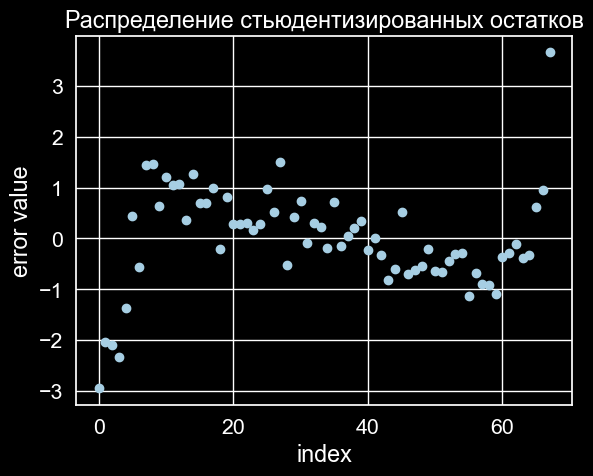

In [176]:
plt.plot(e, 'o')
plt.title("Распределение стьюдентизированных остатков")
plt.ylabel('error value')
plt.xlabel('index');

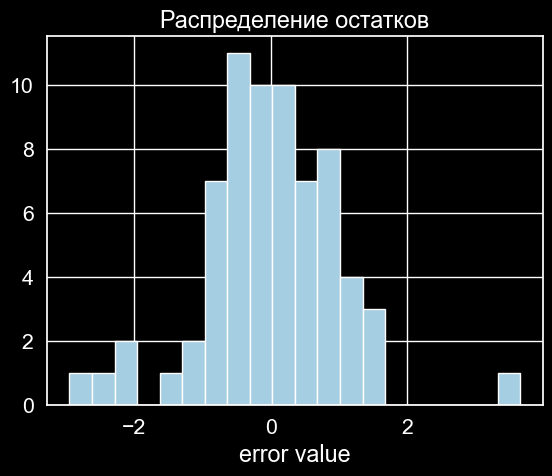

In [177]:
plt.hist(e, bins=20)
plt.title("Распределение остатков")
plt.xlabel('error value');

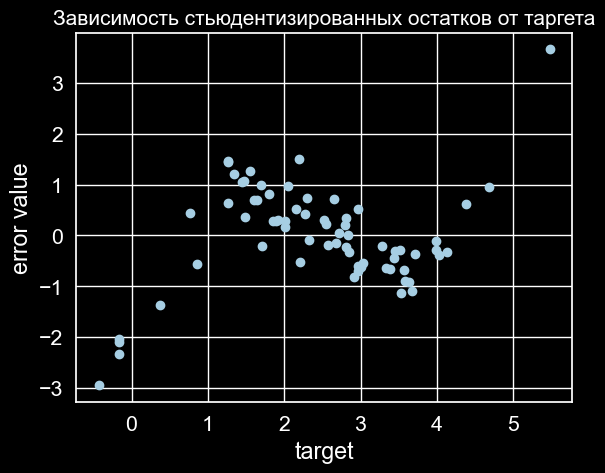

In [178]:
plt.plot(y, e, 'o')
plt.title("Зависимость стьюдентизированных остатков от таргета", fontsize=15)
plt.ylabel('error value')
plt.xlabel('target');

Видна степенная (кубическая) зависимость. Вновь обратимся к RESET Рэмси

In [179]:
#z = cls.predict(X_).reshape((-1, 1))
#Z = [z**i for i in range(2, 15)]  # оптимально до 15 степени, проверено кровью и потом
#X_reset = np.hstack([X_, np.hstack(Z)])  # reshape((-1, 1)) the unspecified value is inferred to be n

In [180]:
X_reset = X_
cls_reset = LinearRegression().fit(X_reset, y)
y_reset = cls_reset.predict(X_reset)
#RSS_new = ((y - y_reset) ** 2).sum()
#F = (RSS - RSS_new) / std

In [181]:
#sps.f.sf(F, 1, n - k - 1)

Таким образом, найдена релевантная модель линейной регрессии

$$y = \beta x + \gamma \hat{y}^2 + \delta \hat{y}^3$$

Увеличение степеней мономов не даёт значимого улучшения 

In [182]:
cls_reset.coef_

array([ 0.13401207,  0.04570975, -0.02654693,  0.02273205, -0.00037299,
        0.00260497, -0.04079086,  0.03934148,  0.05309736])

In [183]:
cls_reset.intercept_

0.5930035123225899

In [184]:
CLS = cls_reset

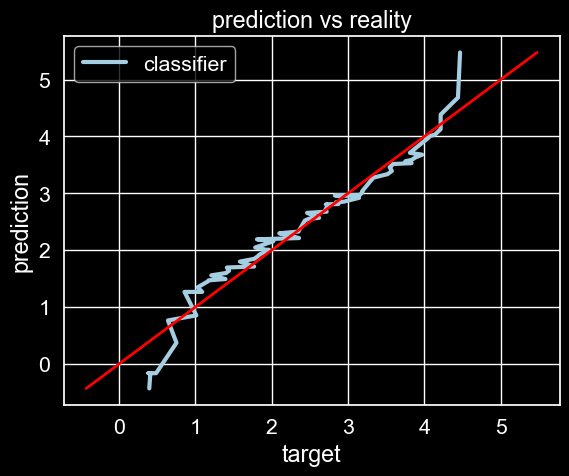

In [185]:
plt.plot(CLS.predict(X_reset), train['lpsa'], linewidth=3, label='classifier')
plt.plot(train['lpsa'], train['lpsa'], linewidth=2, color='red')
plt.xlabel('target')
plt.ylabel('prediction')
plt.title('prediction vs reality')
plt.legend();

In [186]:
CLS.score(X_reset, y)

0.9475288053804853

### Попробуем регуляризировать нашу модель. Для этого воспользуемся Ridge, Lasso и их комбинацией ElasticNet

In [187]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
cls_ridge = Ridge(alpha=0.1).fit(X_reset, y)
score_ridge = cls_ridge.score(X_reset, y)
score_ridge

0.947528663774587

In [188]:
cls_lasso = Lasso(alpha=0.1).fit(X_reset, y)
score_lasso = cls_lasso.score(X_reset, y)
score_lasso

0.9411849493958526

In [189]:
cls_elastic = ElasticNet(alpha=0.1).fit(X_reset, y)
score_elastic = cls_elastic.score(X_reset, y)
score_elastic

0.9422810429359156

Зависимость весов факторов от степени регуляризации:

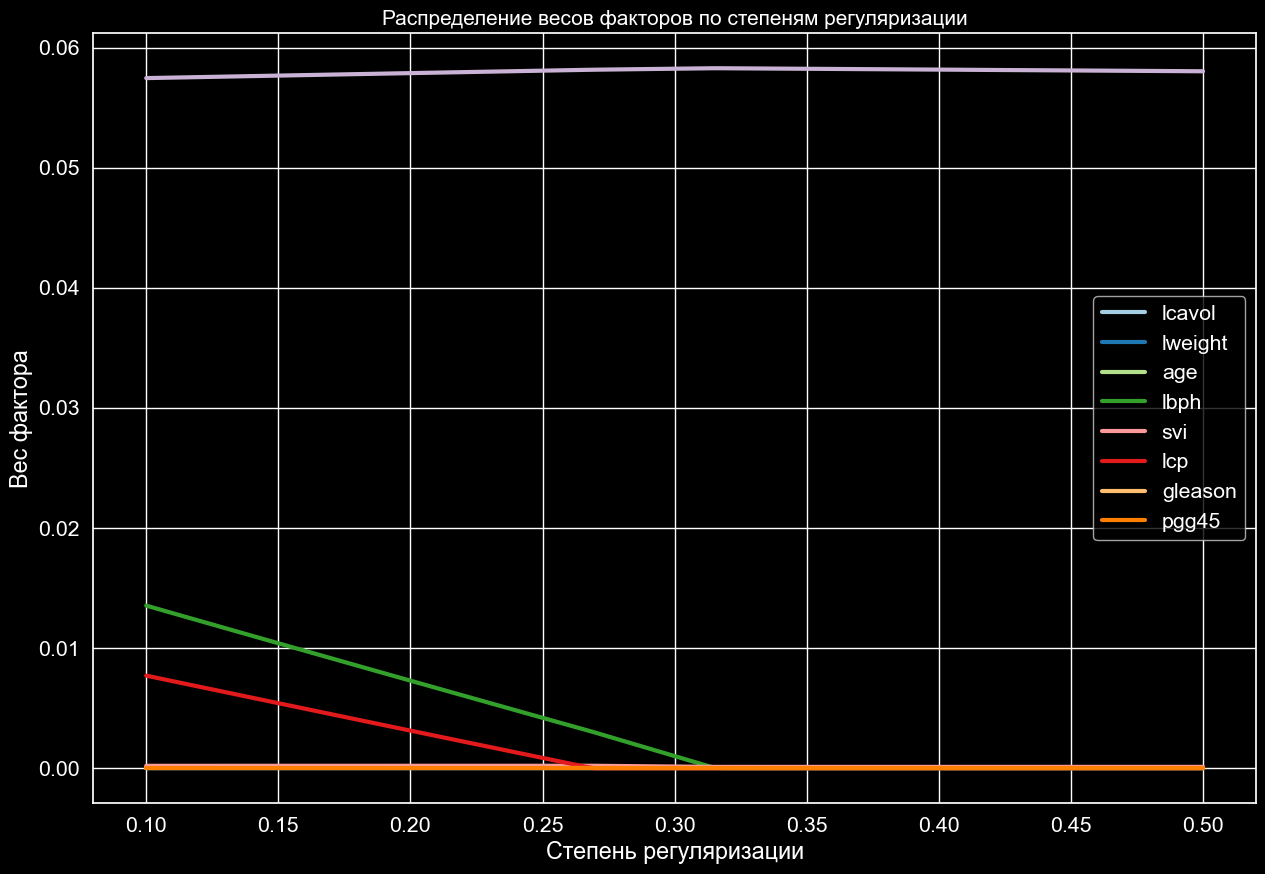

In [190]:
plt.figure(figsize=(15, 10))
x = np.linspace(0.1, 0.5, 100)
plt.plot(x, [ElasticNet(alpha=i).fit(X_reset, y).coef_ for i in x], lw=3)
plt.legend(train.columns[1:-1], loc='best')
plt.title("Распределение весов факторов по степеням регуляризации", fontsize=15)
plt.ylabel("Вес фактора")
plt.xlabel("Степень регуляризации");

Видим, что регурялизация не имеет смысла

## Наконец, предскажем таргет на тестовой выборке

In [191]:
test = df[df['lpsa'].isna() == True].reset_index().drop(columns=['index'])
test

,id,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,7,0.737164,3.473518,64,0.615186,0,-1.386294,6,0,NaN
1,9,-0.776529,3.539509,47,-1.386294,0,-1.386294,6,0,NaN
2,10,0.223144,3.244544,63,-1.386294,0,-1.386294,6,0,NaN
3,15,1.205971,3.442019,57,-1.386294,0,-0.430783,7,5,NaN
4,22,2.059239,3.501043,60,1.474763,0,1.348073,7,20,NaN
5,25,0.385262,3.667400,69,1.599388,0,-1.386294,6,0,NaN
6,26,1.446919,3.124565,68,0.300105,0,-1.386294,6,0,NaN
7,28,-0.400478,3.865979,67,1.816452,0,-1.386294,7,20,NaN
8,34,0.009950,3.267666,54,-1.386294,0,-1.386294,6,0,NaN
9,36,1.308333,4.119850,64,2.171337,0,-1.386294,7,5,NaN


In [192]:
X_test = test.drop(columns=['lpsa', 'id']) # test data
X_test

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
0,0.737164,3.473518,64,0.615186,0,-1.386294,6,0
1,-0.776529,3.539509,47,-1.386294,0,-1.386294,6,0
2,0.223144,3.244544,63,-1.386294,0,-1.386294,6,0
3,1.205971,3.442019,57,-1.386294,0,-0.430783,7,5
4,2.059239,3.501043,60,1.474763,0,1.348073,7,20
5,0.385262,3.667400,69,1.599388,0,-1.386294,6,0
6,1.446919,3.124565,68,0.300105,0,-1.386294,6,0
7,-0.400478,3.865979,67,1.816452,0,-1.386294,7,20
8,0.009950,3.267666,54,-1.386294,0,-1.386294,6,0
9,1.308333,4.119850,64,2.171337,0,-1.386294,7,5


In [193]:
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

n = X_test.shape[0]
k = X_test.shape[1]

In [194]:
X_test_boxcox = np.array([
    sps.boxcox((X_test - X_test.min(axis=0) + 0.001)[:, i])[0] for i in range(k)
]).T

In [195]:
X_test = np.c_[X_test_boxcox, np.arange(n)]
#z = cls_time.predict(X_test).reshape((-1, 1))
#Z = [z**i for i in range(2, 15)]  # оптимально до 15 степени, проверено кровью и потом
#X_test_reset = np.hstack([X_test, np.hstack(Z)])  # reshape((-1, 1)) the unspecified value is inferred to be n

In [196]:
X_test_reset = X_test
y_test = CLS.predict(X_test_reset)
y_test = pd.DataFrame(y_test).rename(columns={0: 'lpsa'})
y_test = pd.DataFrame(np.stack((test['id'], y_test['lpsa']), axis=1)).rename(columns={0: 'id', 1: 'lpsa'})
y_test['id'] = y_test['id'].astype(int)
y_test

,id,lpsa
0,7,0.642142
1,9,0.417991
2,10,0.524834
3,15,0.733048
4,22,1.064776
5,25,0.876776
6,26,0.971004
7,28,0.923139
8,34,0.856792
9,36,1.257233


In [197]:
y_train = train[['id', 'lpsa']]
y_train

,id,lpsa
0,1,-0.430783
1,2,-0.162519
2,3,-0.162519
3,4,-0.162519
4,5,0.371564
...,...,...
63,91,4.029806
64,92,4.129551
65,93,4.385147
66,94,4.684443


In [198]:
ans = pd.DataFrame(np.vstack((y_test, y_train))).rename(columns={0: 'id', 1: 'lpsa'}).sort_values(by='id')
ans = ans.reset_index().drop(columns='index')
ans['id'] = ans['id'].astype(int)
ans

,id,lpsa
0,1,-0.430783
1,2,-0.162519
2,3,-0.162519
3,4,-0.162519
4,5,0.371564
...,...,...
92,93,4.385147
93,94,4.684443
94,95,2.197724
95,96,5.477509


In [199]:
ans.to_csv('msps2018-hw9-2/Prostate_sample.csv', index=False)

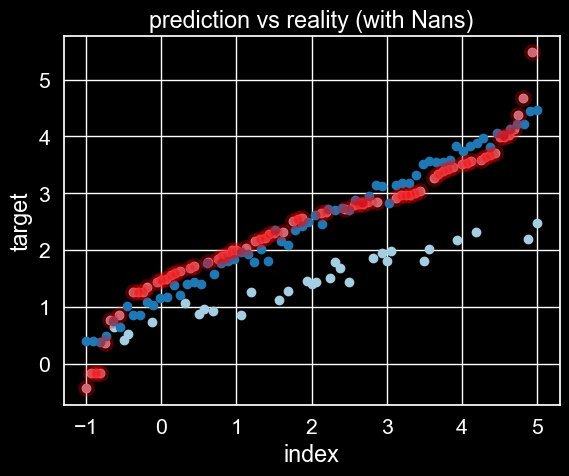

In [200]:
grid = np.linspace(-1, 5, 97)
plt.scatter(grid, ans['lpsa'], label='classifier')
plt.scatter(np.linspace(-1, 5, 68), CLS.predict(X_reset), label='classifier')
plt.scatter(grid, df['lpsa'], color='red', alpha=0.3, lw=6, label='real data')
plt.ylabel('target')
plt.xlabel('index')
plt.title('prediction vs reality (with Nans)');

# Задача 3

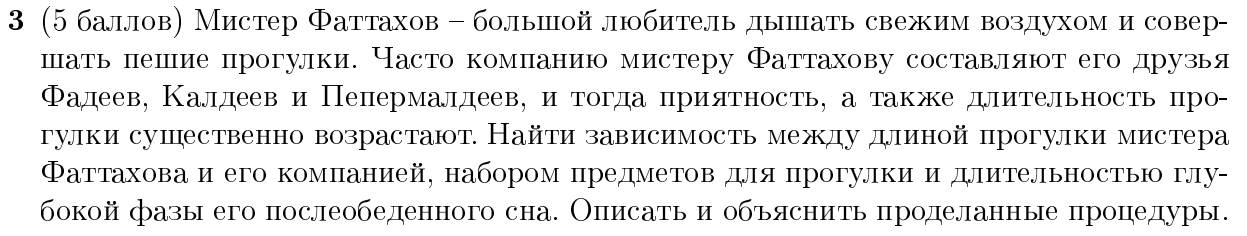

In [201]:
df = pd.DataFrame(pd.read_csv("msps2018-hw9-3/hw9t3_train.csv"))
train = df.dropna(how='any').reset_index().drop(columns=['index'])
train

,id,Fadeev,Khaldeev,Pepermaldeev,kees,top hat,turtle,gloves,small cart,cardboard,...,elefant,zeta function,Alla Pugachyova,soldering iron,frypan,drums,yellow submarine,sleep,mood,duration
0,0,1,1,1,0,0,0,1,1,1,...,0,1,1,0,0,0,1,3.418333,frivolous,11.851099
1,2,0,0,1,1,1,1,1,1,0,...,0,0,0,0,0,1,1,3.229007,so-so,3.751619
2,3,1,1,1,1,1,1,1,1,1,...,1,0,0,1,1,1,0,2.513620,emotional,9.366979
3,7,0,0,0,0,0,0,0,0,1,...,0,1,1,0,1,0,0,3.039107,frivolous,3.130255
4,10,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,1,0,3.770051,apathic,1.545275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,495,0,0,1,1,0,1,1,0,0,...,0,1,0,1,0,1,1,3.246401,apathic,7.854242
374,496,0,1,1,0,1,0,1,0,0,...,1,1,0,0,0,1,1,3.679052,frivolous,6.641359
375,497,1,0,1,1,0,1,0,0,1,...,1,1,0,0,1,1,1,2.970870,frivolous,7.629977
376,498,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,3.111193,good,1.152128


In [202]:
train.columns

Index(['id', 'Fadeev', 'Khaldeev', 'Pepermaldeev', 'kees', 'top hat', 'turtle',
       'gloves', 'small cart', 'cardboard', 'brush', 'toothpaste', 'watch',
       'table', 'flute', 'tallboy', 'drill', 'monkey', 'apple', 'irunine',
       'gel', 'rocket', 'rabbit', 'grand piano', 'whistle', 'Coca-cola',
       'Stanley cup', 'desk', 'elefant', 'zeta function', 'Alla Pugachyova',
       'soldering iron', 'frypan', 'drums', 'yellow submarine', 'sleep',
       'mood', 'duration'],
      dtype='object')

In [203]:
train['mood'].unique()

array(['frivolous', 'so-so', 'emotional', 'apathic', 'good', 'moody',
       'bad', 'excellent'], dtype=object)

In [204]:
train = train.drop(columns=['mood']).join(pd.get_dummies(train['mood']))
train = train.drop(columns=['yellow submarine']).join(pd.get_dummies(train['yellow submarine']))
train = train.drop(columns=['duration']).join(train['duration'])
train = train.astype(float)
train

,id,Fadeev,Khaldeev,Pepermaldeev,kees,top hat,turtle,gloves,small cart,cardboard,...,bad,emotional,excellent,frivolous,good,moody,so-so,0,1,duration
0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,11.851099
1,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,3.751619
2,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.366979
3,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.130255
4,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.545275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,495.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.854242
374,496.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,6.641359
375,497.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,7.629977
376,498.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.152128


In [205]:
X = train.drop(columns=['duration', 'id']) # data
y = train['duration']                      # target

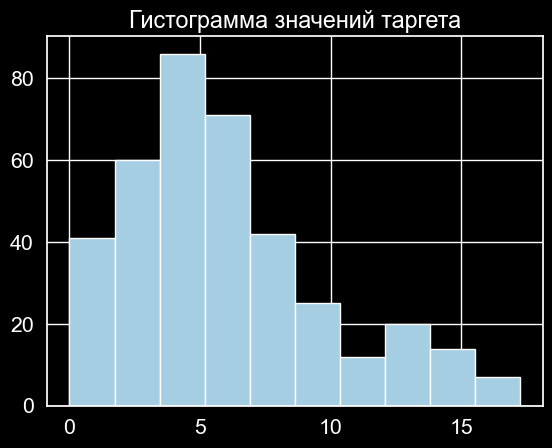

In [206]:
y.hist()
plt.title("Гистограмма значений таргета");

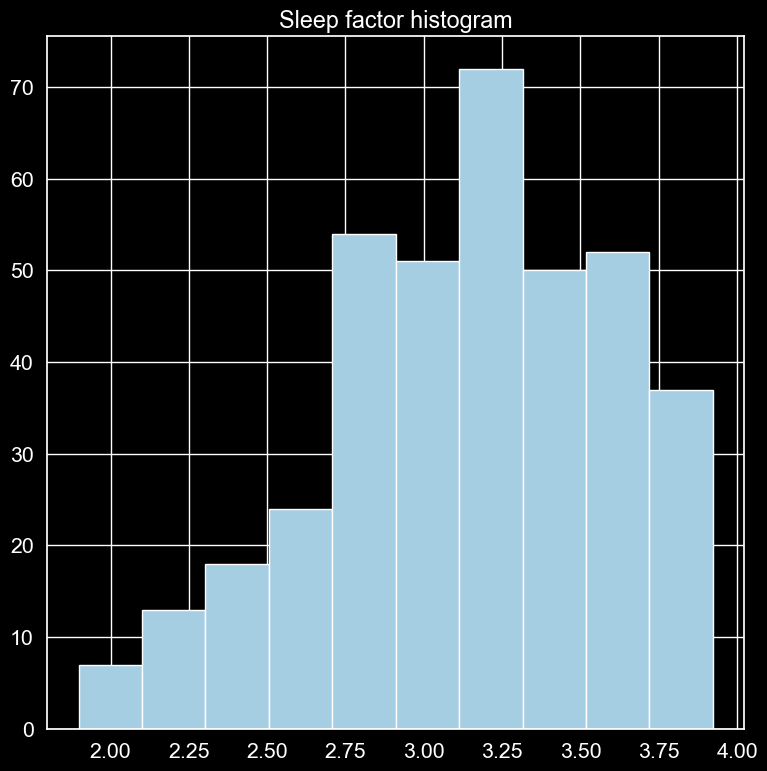

In [207]:
X['sleep'].hist(figsize=(9, 9))
plt.title('Sleep factor histogram');

Нормируем данные

In [208]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

TypeError: Feature names are only supported if all input features have string names, but your input has ['int', 'str'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.

In [209]:
X

,Fadeev,Khaldeev,Pepermaldeev,kees,top hat,turtle,gloves,small cart,cardboard,brush,...,apathic,bad,emotional,excellent,frivolous,good,moody,so-so,0,1
0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
374,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
375,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
376,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


# Задача 4

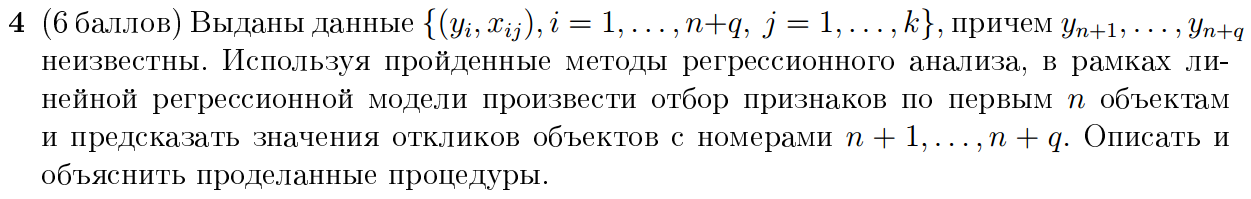

In [210]:
df = pd.DataFrame(pd.read_csv("msps-2018-hw9-4/parkinsons_updrs_train.csv"))
df

,subject#,age,sex,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,...,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,motor_UPDRS_train,total_UPDRS_train,id
0,1,72,0,5.6431,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,...,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006,28.199,34.398,1
1,1,72,0,12.6660,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,...,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810,NaN,NaN,2
2,1,72,0,19.6810,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,...,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014,28.695,35.389,3
3,1,72,0,25.6470,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,...,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277,28.905,35.810,4
4,1,72,0,33.6420,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,...,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361,29.187,36.375,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,42,61,0,142.7900,0.00406,0.000031,0.00167,0.00168,0.00500,0.01896,...,0.01549,0.02920,0.025137,22.369,0.64215,0.55314,0.21367,22.485,33.485,5871
5871,42,61,0,149.8400,0.00297,0.000025,0.00119,0.00147,0.00358,0.02315,...,0.01904,0.03157,0.011927,22.886,0.52598,0.56518,0.12621,21.988,32.988,5872
5872,42,61,0,156.8200,0.00349,0.000025,0.00152,0.00187,0.00456,0.02499,...,0.01877,0.04112,0.017701,25.065,0.47792,0.57888,0.14157,21.495,32.495,5873
5873,42,61,0,163.7300,0.00281,0.000020,0.00128,0.00151,0.00383,0.01484,...,0.01307,0.02078,0.007984,24.422,0.56865,0.56327,0.14204,21.007,32.007,5874


In [211]:
pd.DataFrame(df.isna().sum())

,0
subject#,0
age,0
sex,0
test_time,0
Jitter(%),0
Jitter(Abs),0
Jitter:RAP,0
Jitter:PPQ5,0
Jitter:DDP,0
Shimmer,0


In [212]:
train = df.dropna(how='any').reset_index().drop(columns=['index'])
train

,subject#,age,sex,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,...,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,motor_UPDRS_train,total_UPDRS_train,id
0,1,72,0,5.6431,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,...,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006,28.199,34.398,1
1,1,72,0,19.6810,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,...,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014,28.695,35.389,3
2,1,72,0,25.6470,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,...,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277,28.905,35.810,4
3,1,72,0,33.6420,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,...,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361,29.187,36.375,5
4,1,72,0,40.6520,0.00353,0.000023,0.00119,0.00159,0.00357,0.02227,...,0.02263,0.03019,0.009438,22.946,0.53949,0.57243,0.19500,29.435,36.870,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4389,42,61,0,136.8000,0.00274,0.000021,0.00118,0.00138,0.00355,0.02526,...,0.02108,0.04126,0.006058,23.935,0.45357,0.56142,0.13446,22.908,33.908,5870
4390,42,61,0,142.7900,0.00406,0.000031,0.00167,0.00168,0.00500,0.01896,...,0.01549,0.02920,0.025137,22.369,0.64215,0.55314,0.21367,22.485,33.485,5871
4391,42,61,0,149.8400,0.00297,0.000025,0.00119,0.00147,0.00358,0.02315,...,0.01904,0.03157,0.011927,22.886,0.52598,0.56518,0.12621,21.988,32.988,5872
4392,42,61,0,156.8200,0.00349,0.000025,0.00152,0.00187,0.00456,0.02499,...,0.01877,0.04112,0.017701,25.065,0.47792,0.57888,0.14157,21.495,32.495,5873


In [213]:
X = train.drop(columns=['motor_UPDRS_train', 'total_UPDRS_train', 'id']) # data
y = train[['motor_UPDRS_train', 'total_UPDRS_train']]     # target

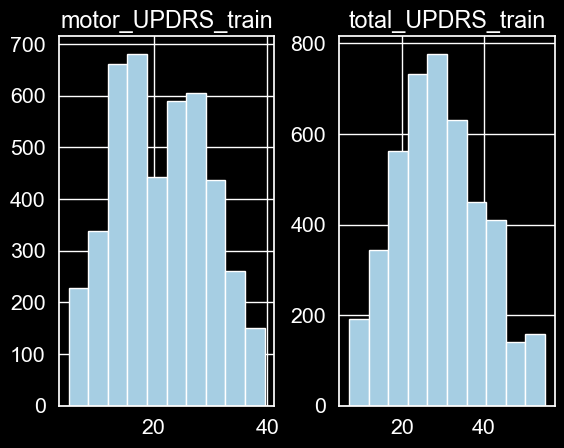

In [214]:
y.hist();

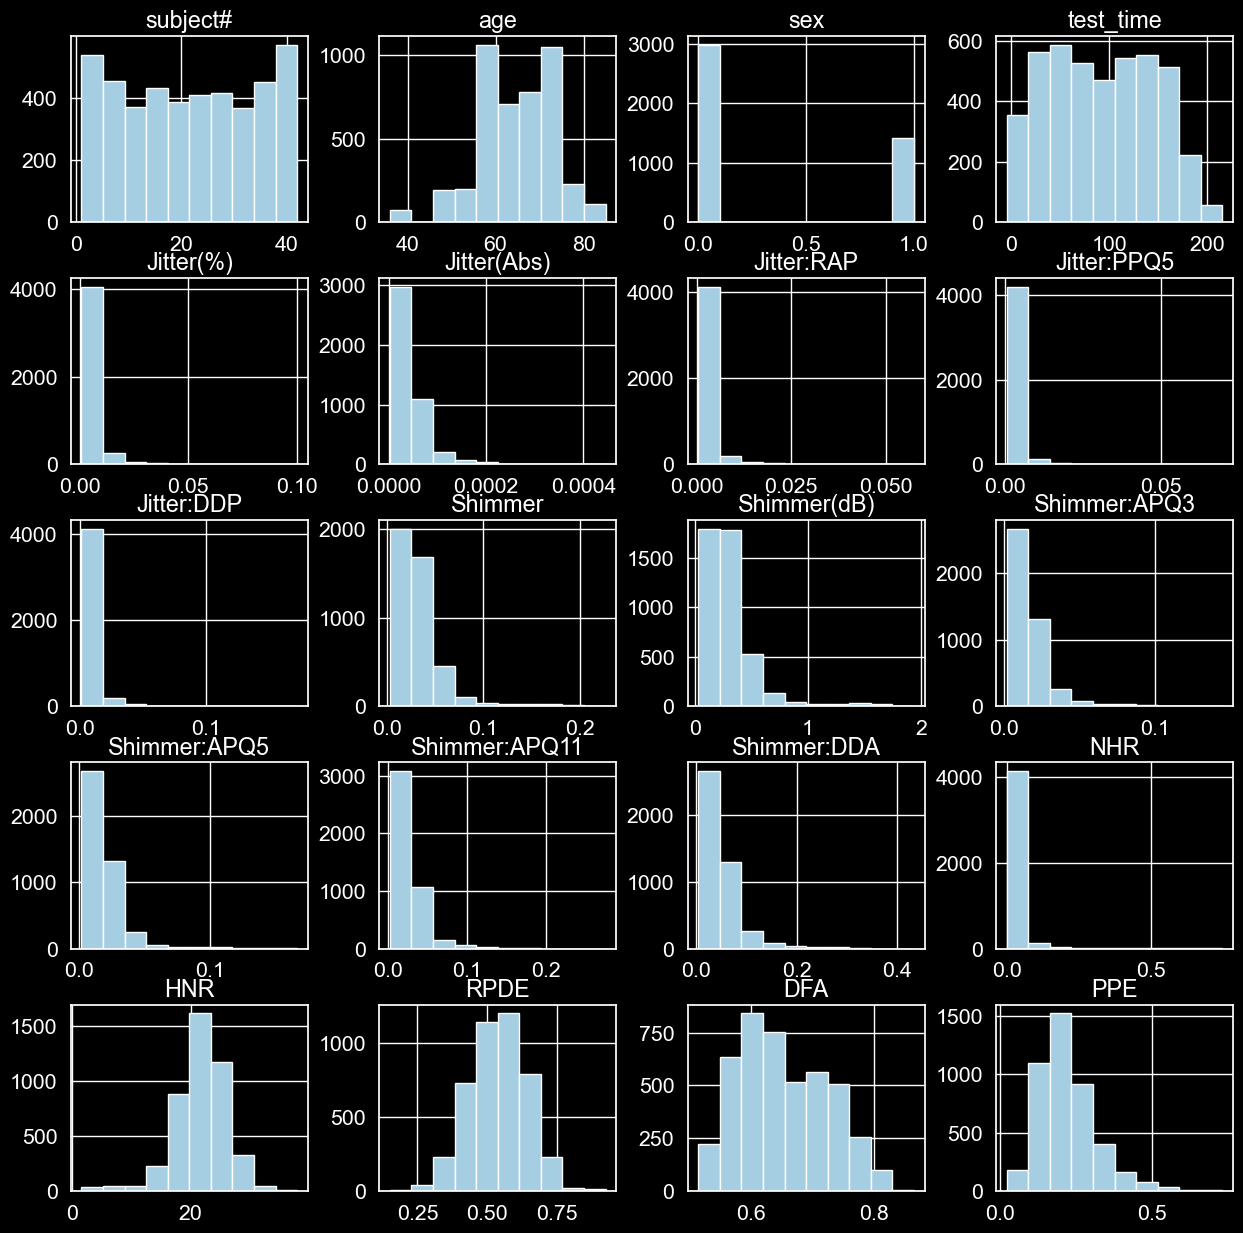

In [215]:
X.hist(figsize=(15, 15));

Стандартизируем данные

In [216]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

Строим регрессию

In [217]:
cls = LinearRegression().fit(X, y);

Коэффициенты(веса)

In [218]:
cls.coef_

array([[ 2.21518513e+00,  1.68527476e+00, -1.15138103e+00,
         5.94844325e-01,  2.29052885e-02, -1.73496390e+00,
        -1.88512749e+02, -5.66982655e-01,  1.90363416e+02,
         1.50080651e+00, -7.44139074e-02, -1.57375873e+02,
        -8.94604288e-01,  7.89972286e-01,  1.55682269e+02,
        -9.16472495e-01, -1.43708528e+00, -1.16658246e-01,
        -1.98871298e+00,  1.56533259e+00],
       [ 3.25246523e+00,  2.69102149e+00, -2.21415294e+00,
         8.61378384e-01, -1.69688239e+00, -1.50592739e+00,
        -1.60570673e+02, -3.67680922e-01,  1.64107491e+02,
         9.60088565e-02,  3.00060122e-01, -4.36963083e+02,
         9.47489395e-01, -6.89116076e-02,  4.34907694e+02,
        -1.45836791e+00, -2.15410555e+00,  1.71508111e-01,
        -2.63395855e+00,  1.46940865e+00]])

Сдвиг

In [219]:
cls.intercept_

array([21.32861468, 29.05628705])

In [220]:
cls.score(X, y)

0.23395010950107914

Коэффициент детерминации $R^2 = 0.23$ достаточно мал. 

Модель нужно улучшать.

In [221]:
RSS = ((y - cls.predict(X)) ** 2).sum()
RSS

motor_UPDRS_train    228701.745159
total_UPDRS_train    378262.827557
dtype: float64

Проверим, есть ли квадратичная зависимость с помощью RESET Рэмси

In [222]:
n = X.shape[0]
k = X.shape[1]
z = cls.predict(X).reshape((-1, 2))
X_reset = np.hstack([X, z ** 2])  # reshape((-1, 1)) the unspecified value is inferred to be n
cls_reset = LinearRegression().fit(X_reset, y)
y_reset = cls_reset.predict(X_reset)

In [223]:
RSS_new = ((y - y_reset) ** 2).sum()
RSS_new

motor_UPDRS_train    217648.527972
total_UPDRS_train    368644.958076
dtype: float64

In [224]:
F = (RSS - RSS_new) / std

In [225]:
sps.f.sf(F, 1, n - k - 1)

array([0., 0.])

F - статистика менее 5%, отвергаем гипотезу, что коэффициенты при степенях таргета одновременно нули

Нормализуем фичи

In [226]:
X_normalized = sklearn.preprocessing.normalize(X)
cls_normalized = LinearRegression().fit(X_normalized, y)
cls_normalized.score(X_normalized, y)

0.24576364974974024

Применим преобразование Бокса-Кокса

In [227]:
X_boxcox = np.array([
    sps.boxcox((X - X.min(axis=0) + 0.001)[:, i])[0] for i in range(k)
]).T
cls_boxcox = LinearRegression().fit(X_boxcox, y)
cls_boxcox.score(X_boxcox, y)

0.2305874453721397

А теперь вместе - Бокс-Кокс для нормализованных

In [228]:
X_norm_boxcox = np.array([
    sps.boxcox((X_normalized - X_normalized.min(axis=0) + 0.001)[:, i])[0] for i in range(k)
]).T
cls_norm_boxcox = LinearRegression().fit(X_norm_boxcox, y)
cls_norm_boxcox.score(X_norm_boxcox, y)

0.22242975344834348

Исходный же коэффициент детерминации $R^2$

In [229]:
cls.score(X, y)

0.23395010950107914

Итого, нормализация даёт небольшой прирост $R^2$, а преобразование Бокса-Кокса его только уменьшает

Применим ортогонализацию Грама-Шмидта:

In [230]:
X_gram_schmidt = np.linalg.qr(X)[0]
cls_gram_schmidt = LinearRegression().fit(X_gram_schmidt, y)
cls_gram_schmidt.score(X_gram_schmidt, y)

0.23395010950108058

Значит, фичи и так почти ортогональны

### 3. Попробуем исключить некоторые признаки

In [231]:
import statsmodels
import statsmodels.stats
import statsmodels.stats.outliers_influence

Variance inflation factor

In [232]:
from statsmodels.tools import add_constant

pd.DataFrame(
    [statsmodels.stats.outliers_influence.variance_inflation_factor(add_constant(X), i), train.columns[i]]
    for i in range(k)
)

,0,1
0,1.000000e+00,subject#
1,1.216537e+00,age
2,1.106120e+00,sex
3,1.427612e+00,test_time
4,1.010509e+00,Jitter(%)
5,8.646656e+01,Jitter(Abs)
6,7.567337e+00,Jitter:RAP
7,1.391185e+06,Jitter:PPQ5
8,3.170096e+01,Jitter:DDP
9,1.391331e+06,Shimmer


Удалим фичу Jitter:RAP

In [233]:
X_no_jitrap = X[:, [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]]
cls_no_temp = LinearRegression().fit(X_no_jitrap, y)
score_no_jitrap = cls_no_temp.score(X_no_jitrap, y)
score_no_jitrap

0.23367736831165914

Теперь $R^2$ только упал

### 4. Не степенные преобразования таргета с таргетом

In [234]:
new_y = np.log(y)**3
cls_square = LinearRegression().fit(X, new_y)
cls_square.score(X, new_y)

0.23855539607868642

Такое преобразование увеличивает $R^2$

### 5. Посмотрим на модель c нормализованными фичами, преобразованным(3 ячейки выше) таргетом и добавленным признаком времени

In [235]:
X_time = np.c_[X_boxcox, np.arange(n)]
cls_time = LinearRegression().fit(X_time, new_y)
score_time = cls_time.score(X_time, new_y)
score_time

0.3223342133533194

In [236]:
print(1 - (1 - score_time) * (n - 1) / (n - k - 1 + 1))

0.31939053481050117


Коэффициент детерминации увеличился

In [237]:
X_ = X_time
y_ = new_y
cls = cls_time
H = X_.dot(np.linalg.inv(X_.T.dot(X_))).dot(X_.T)
RSS = ((y_ - cls.predict(X_)) ** 2).sum()
std = RSS / (n - k - 1)
e = (y_ - cls.predict(X_)) / np.sqrt(std)

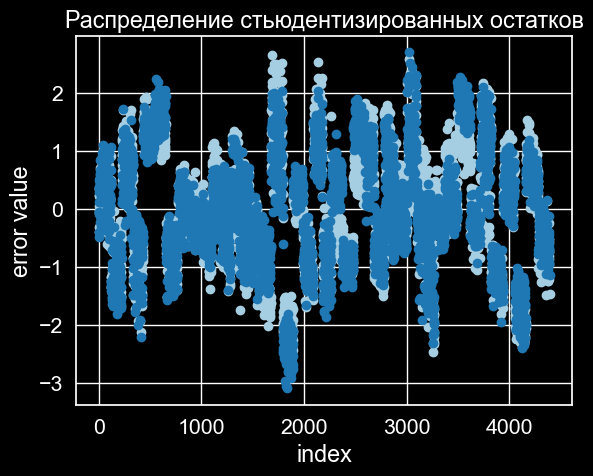

In [238]:
plt.plot(e, 'o')
plt.title("Распределение стьюдентизированных остатков")
plt.ylabel('error value')
plt.xlabel('index');

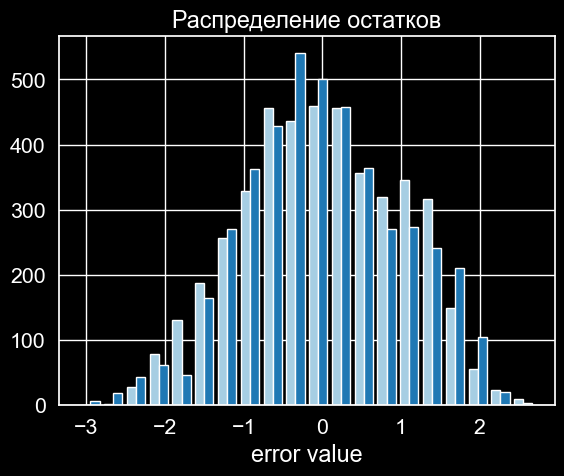

In [239]:
plt.hist(e, bins=20)
plt.title("Распределение остатков")
plt.xlabel('error value');

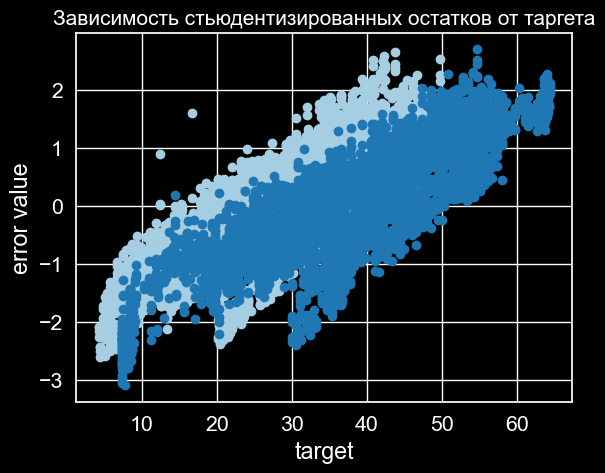

In [240]:
plt.plot(y_, e, 'o')
plt.title("Зависимость стьюдентизированных остатков от таргета", fontsize=15)
plt.ylabel('error value')
plt.xlabel('target');

Однозначно есть тренд. Добавим степени таргета и проверим RESET Рэмси

In [241]:
z = cls.predict(X_).reshape((-1, 2))
Z = [z**i for i in range(2, 3)]  # оптимально до 15 степени, проверено кровью и потом
X_reset = np.hstack([X_, np.hstack(Z)])  # reshape((-1, 1)) the unspecified value is inferred to be n
cls_reset = LinearRegression().fit(X_reset, y_)
y_reset = cls_reset.predict(X_reset)
RSS_new = ((y_ - y_reset) ** 2).sum()
F = (RSS - RSS_new) / std

In [242]:
sps.f.sf(F, 1, n - k - 1)

array([7.80408617e-88, 2.03093219e-60])

Таким образом, найдена релевантная модель линейной регрессии

$$y = \beta x + \gamma \hat{y}^2$$

Увеличение степеней мономов не даёт значимого улучшения 

In [243]:
cls_reset.coef_

array([[-1.09880475e+02,  1.59138970e+01, -8.89926988e-01,
         6.01015063e+00, -1.14568180e+01,  1.62731498e+00,
        -3.16863842e+02, -1.11032421e+01,  3.45747240e+02,
        -2.86509686e+01,  1.88425215e+01, -1.85588999e+03,
         1.56278859e+01,  5.03837407e-01,  1.83708886e+03,
        -1.14626697e+01, -6.73210295e+00,  4.13917835e+00,
        -1.44865243e+01,  1.82920617e+00,  9.34968155e-02,
         5.31180943e-02, -8.82636731e-02],
       [-1.08149547e+02,  1.63063371e+01, -9.09377872e-01,
         6.08306451e+00, -1.26047298e+01,  3.71411768e+00,
        -3.13859942e+02, -1.19488228e+01,  3.43318836e+02,
        -3.01213720e+01,  1.92665088e+01, -1.88707172e+03,
         1.73822369e+01, -8.81367259e-01,  1.86846529e+03,
        -1.17103020e+01, -6.81293628e+00,  4.22613519e+00,
        -1.48190539e+01,  1.67972819e+00,  9.24466061e-02,
         4.55528543e-02, -8.17323792e-02]])

In [244]:
cls_reset.intercept_

array([-59.07387258, -52.47746014])

In [245]:
CLS = cls_reset

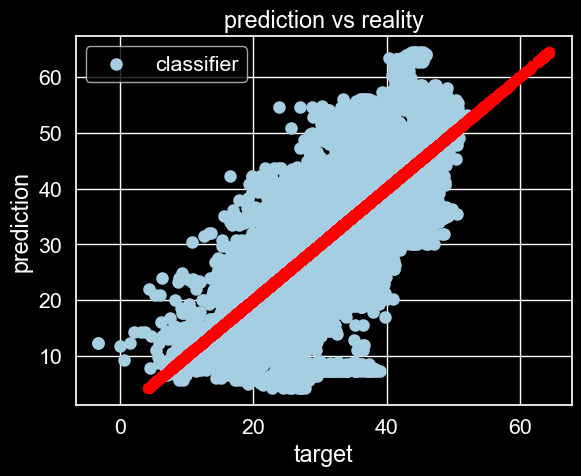

In [246]:
plt.scatter(CLS.predict(X_reset), y_, linewidth=3, label='classifier')
plt.scatter(y_, y_, linewidth=2, color='red')
plt.xlabel('target')
plt.ylabel('prediction')
plt.title('prediction vs reality')
plt.legend();

In [247]:
CLS.score(X_reset, y_)

0.3758051904108483

### Попробуем регуляризировать нашу модель. Для этого воспользуемся Ridge, Lasso и их комбинацией ElasticNet

In [248]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
cls_ridge = Ridge(alpha=0.1).fit(X_reset, y)
score_ridge = cls_ridge.score(X_reset, y)
score_ridge

0.3590261852009896

In [249]:
cls_lasso = Lasso(alpha=0.1).fit(X_reset, y)
score_lasso = cls_lasso.score(X_reset, y)
score_lasso

0.29753460995833975

In [250]:
cls_elastic = ElasticNet(alpha=0.1).fit(X_reset, y)
score_elastic = cls_elastic.score(X_reset, y)
score_elastic

0.2988760853461908

Видим, что регурялизация не имеет смысла

## Наконец, предскажем таргет на тестовой выборке

In [251]:
test = df[df['motor_UPDRS_train'].isna() == True].reset_index().drop(columns=['index'])
test

,subject#,age,sex,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,...,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,motor_UPDRS_train,total_UPDRS_train,id
0,1,72,0,12.666,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,...,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.108100,NaN,NaN,2
1,1,72,0,54.640,0.00476,0.000025,0.00226,0.00259,0.00678,0.02191,...,0.01911,0.02937,0.027969,22.929,0.47712,0.54234,0.238440,NaN,NaN,8
2,1,72,0,82.653,0.00537,0.000032,0.00236,0.00278,0.00709,0.02377,...,0.02395,0.03003,0.017115,24.204,0.46686,0.57984,0.193900,NaN,NaN,12
3,1,72,0,110.650,0.00456,0.000029,0.00152,0.00194,0.00457,0.02878,...,0.02309,0.04138,0.020181,22.203,0.51806,0.56978,0.175080,NaN,NaN,16
4,1,72,0,117.660,0.00693,0.000039,0.00329,0.00285,0.00987,0.02810,...,0.01952,0.04405,0.041980,20.878,0.52874,0.57711,0.349480,NaN,NaN,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1476,42,61,0,106.760,0.00329,0.000024,0.00144,0.00132,0.00432,0.02045,...,0.01776,0.03059,0.010377,24.873,0.51983,0.56668,0.113820,NaN,NaN,5866
1477,42,61,0,115.650,0.00448,0.000036,0.00208,0.00226,0.00625,0.02386,...,0.01971,0.03362,0.035738,21.252,0.62957,0.57942,0.245670,NaN,NaN,5867
1478,42,61,0,121.630,0.00250,0.000019,0.00116,0.00136,0.00347,0.02217,...,0.01987,0.03313,0.012234,20.661,0.47256,0.57177,0.139550,NaN,NaN,5868
1479,42,61,0,128.670,0.00249,0.000021,0.00066,0.00104,0.00198,0.01613,...,0.01997,0.01406,0.007452,25.258,0.52976,0.54378,0.088268,NaN,NaN,5869


In [252]:
X_test = test.drop(columns=['motor_UPDRS_train', 'total_UPDRS_train', 'id']) # test data
X_test

,subject#,age,sex,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,12.666,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.108100
1,1,72,0,54.640,0.00476,0.000025,0.00226,0.00259,0.00678,0.02191,0.212,0.00979,0.01462,0.01911,0.02937,0.027969,22.929,0.47712,0.54234,0.238440
2,1,72,0,82.653,0.00537,0.000032,0.00236,0.00278,0.00709,0.02377,0.282,0.01001,0.01375,0.02395,0.03003,0.017115,24.204,0.46686,0.57984,0.193900
3,1,72,0,110.650,0.00456,0.000029,0.00152,0.00194,0.00457,0.02878,0.264,0.01379,0.01494,0.02309,0.04138,0.020181,22.203,0.51806,0.56978,0.175080
4,1,72,0,117.660,0.00693,0.000039,0.00329,0.00285,0.00987,0.02810,0.274,0.01468,0.01430,0.01952,0.04405,0.041980,20.878,0.52874,0.57711,0.349480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1476,42,61,0,106.760,0.00329,0.000024,0.00144,0.00132,0.00432,0.02045,0.180,0.01020,0.01287,0.01776,0.03059,0.010377,24.873,0.51983,0.56668,0.113820
1477,42,61,0,115.650,0.00448,0.000036,0.00208,0.00226,0.00625,0.02386,0.213,0.01121,0.01475,0.01971,0.03362,0.035738,21.252,0.62957,0.57942,0.245670
1478,42,61,0,121.630,0.00250,0.000019,0.00116,0.00136,0.00347,0.02217,0.193,0.01104,0.01316,0.01987,0.03313,0.012234,20.661,0.47256,0.57177,0.139550
1479,42,61,0,128.670,0.00249,0.000021,0.00066,0.00104,0.00198,0.01613,0.142,0.00469,0.00773,0.01997,0.01406,0.007452,25.258,0.52976,0.54378,0.088268


In [253]:
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)
n = X_test.shape[0]
k = X_test.shape[1]

In [254]:
X_normalized = sklearn.preprocessing.normalize(X_test)

In [255]:
X_test = np.c_[X_normalized, np.arange(n)]
z = cls.predict(X_test).reshape((-1, 2))
Z = [z**i for i in range(2, 3)]  # оптимально до 15 степени, проверено кровью и потом
X_test_reset = np.hstack([X_test, np.hstack(Z)])  # reshape((-1, 1)) the unspecified value is inferred to be n

In [256]:
y_test = CLS.predict(X_test_reset)
y_test = pd.DataFrame(y_test).rename(columns={0: 'motor_UPDRS_train', 1: 'total_UPDRS_train'})
y_test = pd.DataFrame(np.stack((test['id'], y_test['motor_UPDRS_train'], y_test['total_UPDRS_train']), axis=1)).rename(columns={0: 'id', 1: 'motor_UPDRS_train', 2: 'total_UPDRS_train'})
y_test['id'] = y_test['id'].astype(int)
y_test

,id,motor_UPDRS_train,total_UPDRS_train
0,2,-25.096655,-18.402856
1,8,-10.868819,-3.985404
2,12,-6.267352,0.527643
3,16,-6.592627,0.232629
4,17,-6.874732,0.051107
...,...,...,...
1476,5866,-3.316691,4.200388
1477,5867,-8.235064,-0.563030
1478,5868,-3.466483,3.935574
1479,5869,2.704445,10.000438


In [257]:
y_train = train[['id', 'motor_UPDRS_train', 'total_UPDRS_train']]
y_train

,id,motor_UPDRS_train,total_UPDRS_train
0,1,28.199,34.398
1,3,28.695,35.389
2,4,28.905,35.810
3,5,29.187,36.375
4,6,29.435,36.870
...,...,...,...
4389,5870,22.908,33.908
4390,5871,22.485,33.485
4391,5872,21.988,32.988
4392,5873,21.495,32.495


In [258]:
ans = pd.DataFrame(np.vstack((y_test, y_train))).rename(columns={0: 'id', 1: 'motor_UPDRS_train', 2: 'total_UPDRS_train'}).sort_values(by='id')
ans = ans.reset_index().drop(columns='index')
ans['id'] = ans['id'].astype(int)
ans

,id,motor_UPDRS_train,total_UPDRS_train
0,1,28.199000,34.398000
1,2,-25.096655,-18.402856
2,3,28.695000,35.389000
3,4,28.905000,35.810000
4,5,29.187000,36.375000
...,...,...,...
5870,5871,22.485000,33.485000
5871,5872,21.988000,32.988000
5872,5873,21.495000,32.495000
5873,5874,21.007000,32.007000


In [259]:
ans.to_csv("msps-2018-hw9-4/parkinsons_updrs_sample.csv", index=False) 

# Задача 5

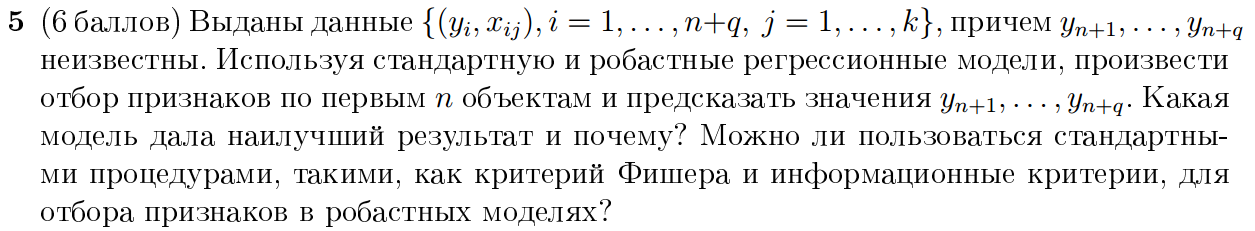